In [1]:
import numpy as np
import keras
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import cv2
# from google.colab.patches import cv2_imshow
import skimage.exposure
import os

In [2]:
!unzip "/Users/Manav/Downloads/mammography_images.zip"

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
train=pd.read_csv("/Users/Manav/Downloads/mammography_images/mammography_images/Training_set.csv")
test=pd.read_csv("/Users/Manav/Downloads/mammography_images/mammography_images/Testing_set.csv")
sub=pd.read_csv("/Users/Manav/Downloads/mammography_images/mammography_images/sample_submission.csv")

In [5]:
train.head()

,filename,label
0,Image_1.jpg,Density3Benign
1,Image_2.jpg,Density1Benign
2,Image_3.jpg,Density1Malignant
3,Image_4.jpg,Density1Benign
4,Image_5.jpg,Density1Malignant


In [6]:
print("len of training set", len(train))
print("len of testing set", len(test))

len of training set 55
len of testing set 1908


In [7]:
(train["label"].value_counts())

Density1Malignant    20
Density2Malignant    14
Density3Benign        9
Density1Benign        6
Density3Malignant     4
Density4Benign        2
Name: label, dtype: int64

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Density3Benign'),
  Text(1, 0, 'Density1Benign'),
  Text(2, 0, 'Density1Malignant'),
  Text(3, 0, 'Density4Benign'),
  Text(4, 0, 'Density2Malignant'),
  Text(5, 0, 'Density3Malignant')])

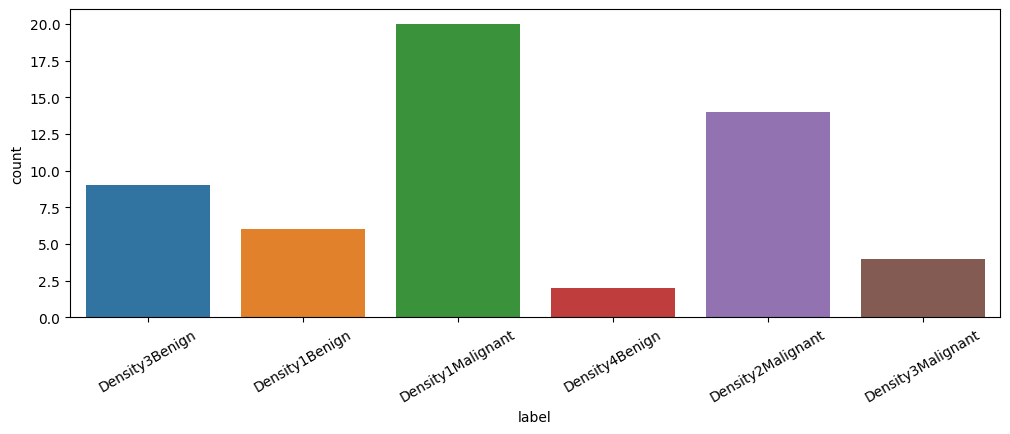

In [8]:
plt.figure(figsize=(12,4))
sns.countplot(x=train["label"],data=train,)
plt.xticks(rotation=30)

In [9]:
train[train["label"]=="Density3Benign"]

,filename,label
0,Image_1.jpg,Density3Benign
6,Image_7.jpg,Density3Benign
19,Image_20.jpg,Density3Benign
24,Image_25.jpg,Density3Benign
33,Image_34.jpg,Density3Benign
37,Image_38.jpg,Density3Benign
38,Image_39.jpg,Density3Benign
43,Image_44.jpg,Density3Benign
53,Image_54.jpg,Density3Benign


In [10]:
def preprocess(image):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    im = cv2.filter2D(image, -1, kernel)
    #out2 = skimage.exposure.rescale_intensity(im, in_range=(150,200), out_range=(0,255))
    out1=(cv2.normalize(im, (224,224),0, 255, cv2.NORM_MINMAX))
    return out1

In [11]:
X_train, X_valid = train_test_split(train, test_size=0.1,stratify=train["label"],shuffle=True)

In [12]:
print("len of training set", len(X_train))
print("len of validation set", len(X_valid))

len of training set 49
len of validation set 6


In [13]:
datagen=ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess)

In [14]:
train_generator=datagen.flow_from_dataframe(
dataframe=X_train,
directory="/Users/Manav/Downloads/mammography_images/mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 49 validated image filenames belonging to 6 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)
(224, 224, 3)


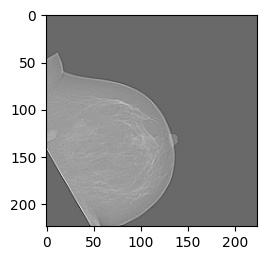

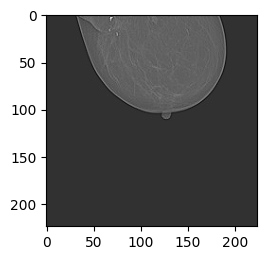

In [15]:
x,y = train_generator.next()
for i in range(2):
    image = x[i]
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)
   
plt.show()

In [16]:
valid_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
valid_generator=valid_datagen.flow_from_dataframe( 
dataframe=X_valid,
directory="/Users/Manav/Downloads/mammography_images/mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 6 validated image filenames belonging to 4 classes.


In [17]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3,DenseNet201,EfficientNetB7, MobileNetV2,Xception,VGG16,NASNetMobile
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import *
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
checkpoint_path = "training_0/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy',verbose = 1,save_weights_only=True, save_best_only = True,mode="max"),
               EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
]

In [19]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [20]:
def build_model():
  model = Sequential()

  conv_base = DenseNet201(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
  model.add(conv_base)  
  model.add(BatchNormalization())
  model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dense(8, activation='softmax'))

  train_layers = [layer for layer in conv_base.layers[::-1][:5]]

  for layer in conv_base.layers:
    if layer in train_layers:
      layer.trainable = True
  return model

In [21]:
my_model=build_model()

In [22]:
initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.1,
    staircase=True)

my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                 metrics=["accuracy"],
                 loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1))


In [24]:
my_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=1,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])

InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Manav\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Manav\AppData\Local\Temp\ipykernel_24192\3850684422.py", line 1, in <module>
      my_model.fit(
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 1984, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "c:\Users\Manav\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5565, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[32,8] labels_size=[32,6]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_85600]

In [ ]:
m.evaluate(valid_generator,verbose=1)

18/18 [==============================] - 7s 136ms/step - loss: 0.6230 - accuracy: 1.0000


[0.6186696290969849, 1.0]

In [ ]:
my_model.load_weights(checkpoint_path)

In [ ]:
my_model.evaluate(valid_generator,verbose=1)

18/18 [==============================] - 3s 135ms/step - loss: 0.6187 - accuracy: 1.0000


[0.6186696290969849, 1.0]

In [ ]:
train_generator.class_indices

{'Density1Benign': 0,
 'Density1Malignant': 1,
 'Density2Benign': 2,
 'Density2Malignant': 3,
 'Density3Benign': 4,
 'Density3Malignant': 5,
 'Density4Benign': 6,
 'Density4Malignant': 7}

In [26]:
test_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
test_generator=valid_datagen.flow_from_dataframe(
dataframe=test,
directory="/Users/Manav/Downloads/mammography_images/mammography_images/test",
x_col="filename",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

NameError: name 'valid_datagen' is not defined

In [ ]:
pred1=np.argmax(my_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1),axis=1)

1908/1908 [==============================] - 44s 23ms/step


In [ ]:
pred1

array([4, 0, 3, ..., 3, 3, 3])

In [ ]:
sub["label"]=pred1
sub["label"]=sub["label"].map({0:'Density1Benign',
 1:'Density1Malignant',
 2:'Density2Benign',
 3:'Density2Malignant',
 4: 'Density3Benign',
 5: 'Density3Malignant',
 6:'Density4Benign',
 7:  'Density4Malignant'})

In [ ]:
sub["label"].value_counts()

Density2Malignant    576
Density1Malignant    540
Density3Benign       234
Density1Benign       216
Density3Malignant    144
Density4Benign       108
Density2Benign        72
Density4Malignant     18
Name: label, dtype: int64

In [1]:
sub.to_csv("9.csv",index=False)

NameError: name 'sub' is not defined